# Hyper Parameter Tuning

- 다양한 케이스에서 튜닝을 시도했으나 기본 파생변수 + 날짜 관련 파생변수 + 위법물 관련 파생변수에 기존 칼럼을 더할 시에 과적합이 제어가 안되는 (Precision > 0.99) 현상 발생

- 따라서 44_Basic_Date_Illegal.pkl를 사용하여 튜닝 진행

In [1]:
import numpy as np
import pandas as pd
import warnings
import sys
warnings.filterwarnings('ignore')

## Label Encoding

- 해당 데이터셋을 Label Encoding, One-hot Encoding 해본 결과 Label Encoding이 더 precision이 높으므로 Label Encoding 사용

In [2]:
def syspath(path) :
  if path not in sys.path :
    sys.path.append(path)
  else : pass

In [3]:
import sys
syspath('./dataset/mod')
from Preprocessing import Encoder
from Modeling import Algorithm

In [5]:
df = pd.read_pickle('./dataset/44_Basic_Date_Illegal.pkl')
en = Encoder(df)
le_df = en.label()
le_df

,R6M_CON_IMP_CNT,R6M_CON_IMP_AMT,R6M_CON_NUMB_OF_INSPECTION,R6M_CON_NUMB_OF_DETECTED,R6M_CON_RATIO_OF_DETECTED,R6M_CODE_IMP_CNT,R6M_CODE_IMP_AMT,R6M_CODE_NUMB_OF_INSPECTION,R6M_CODE_NUMB_OF_DETECTED,R6M_COUNTRY_IMP_CNT,...,R6M_COUNTRY_RATIO_OF_DETECTED,R6M_REP_IMP_CNT,R6M_REP_IMP_AMT,R6M_REP_NUMB_OF_INSPECTION,R6M_REP_NUMB_OF_DETECTED,R6M_REP_RATIO_OF_DETECTED,C_MONTH,A_HOUR,CON_ILLEGAL_RATIO,LABEL
0,3,800099.23,0,0,0.0,0,0.0,0,0,9360,...,0.0,2695,1.915663e+09,0,0,0.0,1,11,0.000000,0
1,3,800099.23,0,0,0.0,0,0.0,0,0,9360,...,0.0,2695,1.915663e+09,0,0,0.0,1,11,0.000000,0
2,3,800099.23,0,0,0.0,0,0.0,0,0,9360,...,0.0,2695,1.915663e+09,0,0,0.0,1,11,0.000000,0
3,6,1395774.24,0,0,0.0,49,7322224.0,0,0,72,...,0.0,2695,1.915663e+09,0,0,0.0,1,15,0.000000,0
4,6,1395774.24,0,0,0.0,49,7322224.0,0,0,72,...,0.0,2695,1.915663e+09,0,0,0.0,1,15,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2146503,28,3697469.32,0,0,0.0,1715,74123910.4,0,0,3264,...,0.0,1508,3.124966e+08,0,0,0.0,10,11,0.002103,0
2146504,28,3697469.32,0,0,0.0,1715,74123910.4,0,0,3264,...,0.0,1508,3.124966e+08,0,0,0.0,10,11,0.002103,0
2146505,28,3697469.32,0,0,0.0,1715,74123910.4,0,0,3264,...,0.0,1508,3.124966e+08,0,0,0.0,10,11,0.002103,0
2146506,6,2306035.03,0,0,0.0,70,1672623.4,0,0,4021,...,0.0,1558,1.297993e+09,0,0,0.0,10,16,0.000000,0


## Train Test Split

- test_size = 0.2
- 데이터 불균형을 해소하기 위하여 계통 추출법 적용

In [8]:
from sklearn.model_selection import train_test_split

X_features = le_df.drop('LABEL', axis=1)
y_label = le_df.LABEL

X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, train_size=0.8, test_size=0.2, random_state=0, stratify=y_label)

## GridSearchCV

- 먼저 과적합을 제어하기 위하여 아래의 hyper parameter들 부터 tuning
    - max_depth
    - min_child_samples
    - num_leaves < 2^max_depth
    - subsample

- 이후 평가 개선을 위하여 아래의 hyper parameter들 tuning
    - n_estimators는 최대로, learning_rate는 최소로 조정
    - n_estimators
    - learning_rate

In [21]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

lgb_wrapper = LGBMClassifier(boost_from_average=False)
params = {}

# 과적합 제어
params['max_depth'] = [30, 32, 34]
params['min_child_samples'] = [35, 40, 45]
params['num_leaves'] = [360, 370, 380]
params['subsample'] = [0, 0.05, 0.1]
# 평가 결과 개선
params['learning_rate'] = [0.05, 0.1, 0.15]
params['n_estimators'] = [215, 225, 235]

gridcv=GridSearchCV(lgb_wrapper, param_grid=params, cv=3)

# 조기중단 수행
gridcv.fit(X_train,y_train, early_stopping_rounds=100,eval_metric='logloss',
                eval_set=[(X_train,y_train), (X_test,y_test)])
print('GridSearchCV 최적 파라미터:', gridcv.best_params_)

	valid_1's binary_logloss: 0.00337042
[159]	valid_0's binary_logloss: 0.00152696	valid_1's binary_logloss: 0.00337832
[160]	valid_0's binary_logloss: 0.00152653	valid_1's binary_logloss: 0.00338432
[161]	valid_0's binary_logloss: 0.00152733	valid_1's binary_logloss: 0.00339134
[162]	valid_0's binary_logloss: 0.00153016	valid_1's binary_logloss: 0.00339943
[163]	valid_0's binary_logloss: 0.00153278	valid_1's binary_logloss: 0.00340563
[164]	valid_0's binary_logloss: 0.00153502	valid_1's binary_logloss: 0.00341502
[165]	valid_0's binary_logloss: 0.00153449	valid_1's binary_logloss: 0.00341774
[166]	valid_0's binary_logloss: 0.00153652	valid_1's binary_logloss: 0.00342518
[167]	valid_0's binary_logloss: 0.00153907	valid_1's binary_logloss: 0.00343779
[168]	valid_0's binary_logloss: 0.00154172	valid_1's binary_logloss: 0.0034439
[169]	valid_0's binary_logloss: 0.00154533	valid_1's binary_logloss: 0.00345369
[170]	valid_0's binary_logloss: 0.00154847	valid_1's binary_logloss: 0.00346585
[17

## LightGBM

- 과적합 제어
    - max_depth=32
    - min_child_samples=40
    - num_leaves=370
    - subsample=0.05

- 평과 결과 개선
    - learning_rate=0.1
    - n_estimators=225



In [15]:
# 평가를 위한 사용자 함수
def clf_eval(y_test, preds) :

  from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

  confusion = confusion_matrix(y_test, preds)
  accuracy = accuracy_score(y_test, preds)
  precision = precision_score(y_test, preds)
  recall = recall_score(y_test, preds)
  f1 = f1_score(y_test, preds)

  print('Confusion Matrix')
  print(confusion)
  print('Accuracy : {0:.4f}\nPrecision : {1:.4f}\nRecall : {2:.4f}\nf1 score : {3:.4f}'.format(accuracy, precision, recall, f1))

[1]	valid_0's binary_logloss: 0.598799
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.521503
[3]	valid_0's binary_logloss: 0.457026
[4]	valid_0's binary_logloss: 0.402532
[5]	valid_0's binary_logloss: 0.355943
[6]	valid_0's binary_logloss: 0.315822
[7]	valid_0's binary_logloss: 0.281019
[8]	valid_0's binary_logloss: 0.250667
[9]	valid_0's binary_logloss: 0.224053
[10]	valid_0's binary_logloss: 0.200652
[11]	valid_0's binary_logloss: 0.179972
[12]	valid_0's binary_logloss: 0.161675
[13]	valid_0's binary_logloss: 0.145431
[14]	valid_0's binary_logloss: 0.130978
[15]	valid_0's binary_logloss: 0.11808
[16]	valid_0's binary_logloss: 0.10658
[17]	valid_0's binary_logloss: 0.0962936
[18]	valid_0's binary_logloss: 0.087074
[19]	valid_0's binary_logloss: 0.0788142
[20]	valid_0's binary_logloss: 0.0714027
[21]	valid_0's binary_logloss: 0.0647402
[22]	valid_0's binary_logloss: 0.0587553
[23]	valid_0's binary_logloss: 0.0533675
[24]	valid_0's binary_lo

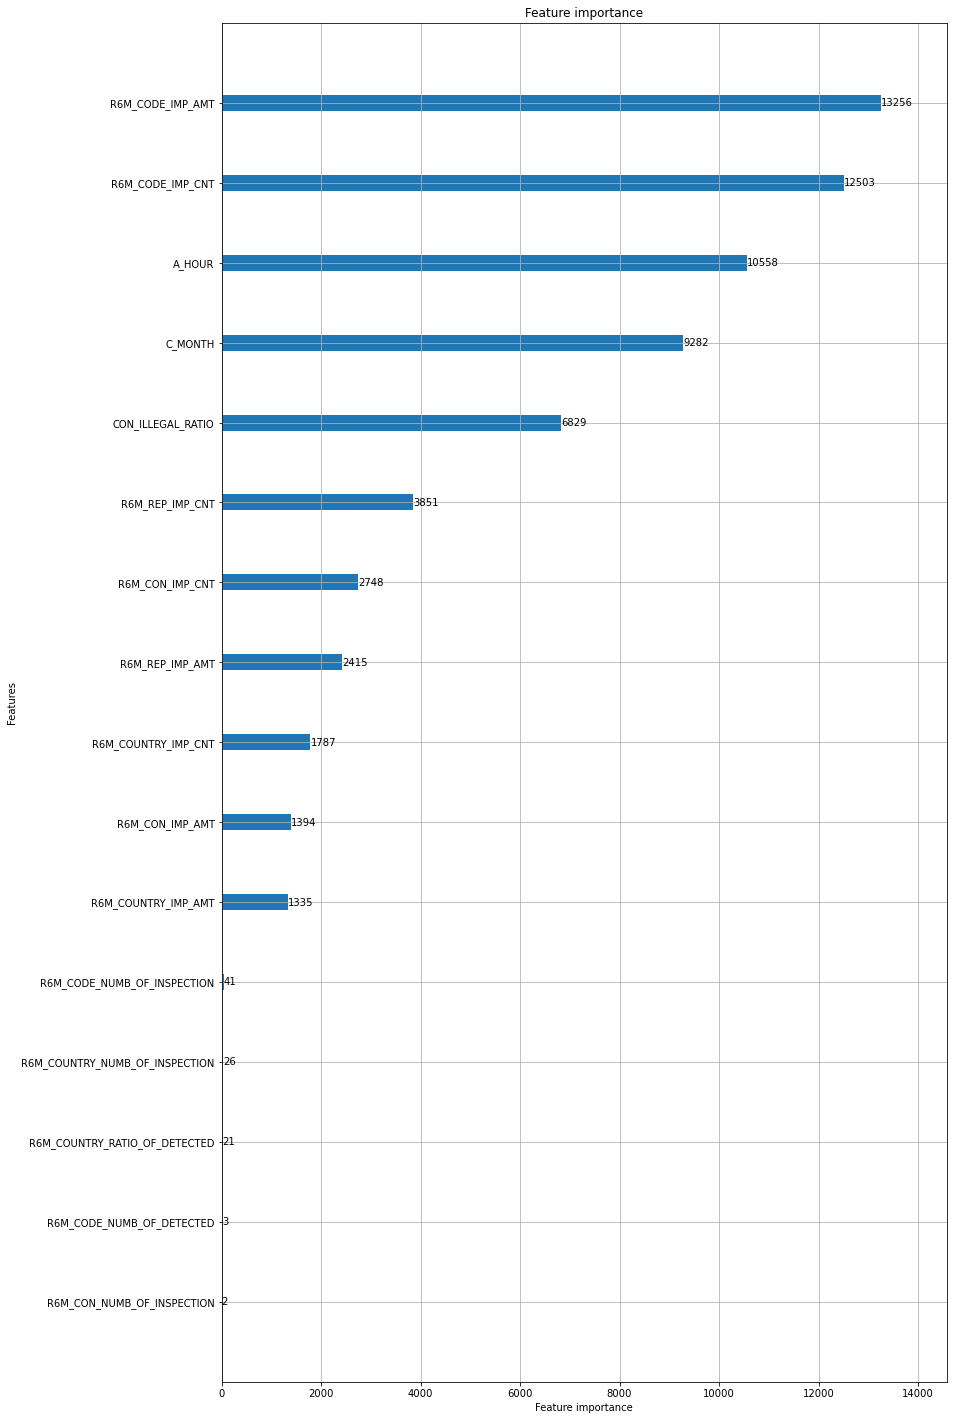

In [22]:
from lightgbm import LGBMClassifier

lgb_wrapper = LGBMClassifier(max_depth=32, min_child_samples=40, num_leaves=370,
                             subsample=0.05, boost_from_average=False,
                             learning_rate=0.1, n_estimators=225)
evals = [(X_test, y_test)]

# 조기중단 수행
lgb_wrapper.fit(X_train,y_train, early_stopping_rounds=10,eval_set=evals,
                eval_metric='logloss')
preds = lgb_wrapper.predict(X_test)

# 평가 시행
clf_eval(y_test, preds)

# Feature Importance Visualization
from lightgbm import plot_importance
import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize=(13,25))
plot_importance(lgb_wrapper, ax=ax)

In [23]:
# 학습된 모델을 pickle 파일로 저장
import pickle
with open('./dataset/trained_LGBM.pkl', 'wb') as f :
  pickle.dump(lgb_wrapper, f)